Project Start Date: 17th December 2020 <br> <br>

Data Sources <br>
https://www.kaggle.com/usaf/world-war-ii/notebooks <br> 
https://www.kaggle.com/smid80/weatherww2/data <br>

**Aim of this project** <br>
Aerial Bombing Operations in WW2 - Bombing operations data <br>

This dataset consists of digitized paper mission reports from WWII. Each record includes the date, conflict, geographic location, and other data elements to form a live-action sequence of air warfare from 1939 to 1945. The records include U.S. and Royal Air Force data, in addition to some Australian, New Zealand and South African air force missions.

Since our project team did not participate in planning the study or data collection, it is possible that we are missing crucial context which could render our conclusions invalid. <br>

Weather Conditions in WW2 (Weather Stations / Weather Conditions) <br>
The dataset contains information on weather conditions recorded on each day at various weather stations around the world. Information includes precipitation, snowfall, temperatures, wind speed and whether the day included thunder storms or other poor weather conditions.

**Objectives & Hypothesises to Test (max. 8)** <br>
<u>Exploratory Analysis</u>
- What is the distribution of bombings per region?
https://towardsdatascience.com/ridgeline-plots-the-perfect-way-to-visualize-data-distributions-with-python-de99a5493052
- How does weather impact bombing accuracy/number of bombings occurring?
- What do patterns show before & after D-day?
<br>

<u>Statistical Model/Machine Learning Applications</u>
- Is there a relationship between the daily minimum and maximum temperature (TimeSeries Analysis)? 
- Predict the average temperature based on the independent variables given
- Can you predict the maximum temperature given the minimum temperature (GLM Models & Bayesian Versions)?
- Plot learning curves to deduce high bias/high variance and conclude what means could be applied to solve these issues

**Analysis regarding Data Quality** <br>
- Understanding of the sampling procedure <br>
- Potential biases <br> 
- Real-world actions that generated the data you inherited <br>

**Applications of Data Science Applied** <br>
- Explain the train/test split
- Explain appropriate error metric
- Explain class balance and any required action
- Explain what features are developed and transformations applied
- Explain if the model is exhibiting high bias or high variance and how this can be improved
- Explain where the model seems to perform poorly - In what situations does the model make mistakes?

**Additional Learning notes and next steps** <br>

## Problem Framing,
- Define a strategy
- Define your project goals
- What do you want to find out? 
- Do you have the data to analyze?

In [1]:
# Package --- These should be added to a requirements file
import os
import pandas as pd
import numpy as np

In [2]:
os.getcwd()

'/Users/Rej1992/Documents/GitHub/RegressionModels/notebooks'

In [3]:
aerial_bombing_data = pd.read_csv('/Users/Rej1992/Documents/GitHub/RegressionModels/data/01_raw/ww2_boming_operations.csv')
weather_summary = pd.read_csv('/Users/Rej1992/Documents/GitHub/RegressionModels/data/01_raw/WeatherTempPrediction.csv')
weather_station_location = pd.read_csv('/Users/Rej1992/Documents/GitHub/RegressionModels/data/01_raw/WeatherStationLocations.csv')

data_list = []
data_list.append(aerial_bombing_data)
data_list.append(weather_summary)
data_list.append(weather_station_location)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (7,8,11,13,31,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (7,8,18,25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Data Quality Expectations (no columns without variance, no duplicates, no contradictions, etc.)
# State the assumptions you’re being forced to make.
# Write up caveat notes to be included in the appendix of your final report
# Write cautionary notes that warn the decision-maker (and your other readers) that conclusions from the study will 
# need to be downgraded due to potential data issues
# I want to know what columns in each dataset permit the potential to create the best unique key for joining 

In [5]:
for i in data_list:
    print("Dataframe Dimensions")
    print(i.shape)
    print("")

    print("Dataframe Columns and respective types")
    print(i.dtypes)
    print("")

    print("Percentage of Missing Data")
    print(i.isnull().sum() * 100 / len(i))
    
    print("")

Dataframe Dimensions
(178281, 46)

Dataframe Columns and respective types
Mission ID                                 int64
Mission Date                              object
Theater of Operations                     object
Country                                   object
Air Force                                 object
Unit ID                                   object
Aircraft Series                           object
Callsign                                  object
Mission Type                              object
Takeoff Base                              object
Takeoff Location                          object
Takeoff Latitude                          object
Takeoff Longitude                        float64
Target ID                                 object
Target Country                            object
Target City                               object
Target Type                               object
Target Industry                           object
Target Priority                           ob

## Data Analysis
- Data visualization of features
- Handling categorical data
- Encoding class labels
- Normalization and standardization of features
- Dimensionality Reduction
- Data partitioning into training, validation and testing sets

In [6]:
# Handling missing data - Remove any columns with over 90% missing data 
thresold_limit = 0.9
data_remove_missing = []

for j in data_list:
    j = j.loc[:, j.isnull().sum() < thresold_limit*j.shape[0]]
    data_remove_missing.append(j)
    print(j.shape)

(178281, 26)
(119040, 17)
(161, 8)


In [7]:
for j in data_remove_missing:
    print(j.columns)
    print("")

Index(['Mission ID', 'Mission Date', 'Theater of Operations', 'Country',
       'Air Force', 'Unit ID', 'Aircraft Series', 'Mission Type', 'Target ID',
       'Target Country', 'Target City', 'Target Type', 'Target Industry',
       'Target Priority', 'Target Latitude', 'Target Longitude',
       'Altitude (Hundreds of Feet)', 'Airborne Aircraft',
       'Attacking Aircraft', 'Bombing Aircraft', 'High Explosives',
       'High Explosives Type', 'High Explosives Weight (Tons)',
       'Incendiary Devices Weight (Tons)', 'Total Weight (Tons)', 'Source ID'],
      dtype='object')

Index(['STA', 'Date', 'Precip', 'MaxTemp', 'MinTemp', 'MeanTemp', 'Snowfall',
       'PoorWeather', 'YR', 'MO', 'DA', 'PRCP', 'MAX', 'MIN', 'MEA', 'SNF',
       'TSHDSBRSGF'],
      dtype='object')

Index(['WBAN', 'NAME', 'STATE/COUNTRY ID', 'LAT', 'LON', 'ELEV', 'Latitude',
       'Longitude'],
      dtype='object')



### Weather Summary Analysis

**Hypothesis & Expectations to Test**
- What are the locations associated with the study?
- It is expected that average temperatures are colder in winter months than summer months
- It is expected that more snowfall occurs in the winter months (for northern hemisphere regions)
- It is expected that more Precipitation occurs in the winter months (for northern hemisphere)
- It is expected that lower temperatures correlate with higher snowfall and precipation 
- It is expected that the accuracy of recordings based on stations may not be uniform (outlier detection)

In [33]:
weather_summary.columns

Index(['STA', 'Precip', 'Snowfall', 'YR', 'MO', 'DA', 'MAX', 'MIN', 'SNF',
       'MeanTemp_F', 'Snowfall_bin'],
      dtype='object')

In [8]:
# Analysis for the weather_summary
weather_summary = data_remove_missing[1] # N.B This will overwrite the dataframe created above
weather_station_location = data_remove_missing[2] # N.B This will overwrite the dataframe created above

## Notes for each column:
## STA: represent the Weather Station
## Not all STA codes represent the same time frequency 

## Date: Date has been split into DA MO and YR respectively, note the century has been dropped when recording the YR

## Precip: Precipitation in mm. This consists of numerical values and 'T' for 16,754 entries. This looks to be a mistake in the data collection
## Impute precip == 0 for these cases

## MaxTemp and MinTemp are features that have been transformed into celcius from fahrenheit readings MAX/MIN 
## and these have been recorded to 6 decimal places. The degrees celcius value has additionally been converted to an
## average. Using celcius will have a smaller range than the fahrenheit records. Patterns may be more easily seen 
## based fahrenheit columns 
## MEA is the mean for the fahrenheit MAX / MIN columns and this has been rounded to 1 d.p. Drop this columns and 
## calculate the extact mean value

## Snowfall
## This looks to be measures in terms of the amount of snow that fell in mm. The units are not obvious so there are two options
## Either assume the units are centiments by attempting to research more about the data OR
## Normalise all the columns so they are on the same scale

## SNF
## After research it is unclear what SNF relates to - It seems to gave a range of 0 - 3.4 

## PRCP
## This column looks to have been scaled by a factor of 1/25.4*Precip - Agree to remove

## TSHDSBRSGF
## This is a repeat for PoorWeather so can be removed

In [9]:
weather_summary.head()

,STA,Date,Precip,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,MO,DA,PRCP,MAX,MIN,MEA,SNF,TSHDSBRSGF
0,10001,1942-7-1,1.016,25.555556,22.222222,23.888889,0,NaN,42,7,1,0.04,78.0,72.0,75.0,0,NaN
1,10001,1942-7-2,0,28.888889,21.666667,25.555556,0,NaN,42,7,2,0,84.0,71.0,78.0,0,NaN
2,10001,1942-7-3,2.54,26.111111,22.222222,24.444444,0,NaN,42,7,3,0.1,79.0,72.0,76.0,0,NaN
3,10001,1942-7-4,2.54,26.666667,22.222222,24.444444,0,NaN,42,7,4,0.1,80.0,72.0,76.0,0,NaN
4,10001,1942-7-5,0,26.666667,21.666667,24.444444,0,NaN,42,7,5,0,80.0,71.0,76.0,0,NaN


In [10]:
weather_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   STA          119040 non-null  int64  
 1   Date         119040 non-null  object 
 2   Precip       119040 non-null  object 
 3   MaxTemp      119040 non-null  float64
 4   MinTemp      119040 non-null  float64
 5   MeanTemp     119040 non-null  float64
 6   Snowfall     117877 non-null  object 
 7   PoorWeather  34237 non-null   object 
 8   YR           119040 non-null  int64  
 9   MO           119040 non-null  int64  
 10  DA           119040 non-null  int64  
 11  PRCP         117108 non-null  object 
 12  MAX          118566 non-null  float64
 13  MIN          118572 non-null  float64
 14  MEA          118542 non-null  float64
 15  SNF          117877 non-null  object 
 16  TSHDSBRSGF   34237 non-null   object 
dtypes: float64(6), int64(4), object(7)
memory usage: 15.4+ MB


**Data Cleaning - Remove Selected Columns**
- Remove celcius columns 'MaxTemp', 'MinTemp', 'MeanTemp' and 'MEA'
- Remove duplicated/scaled columns: 'PRCP', 'TSHDSBRSGF'
- Remove PoorWeather for the inital analysis as unclear how the data has been recorded 

In [11]:
weather_summary.drop(['MaxTemp', 
                      'MinTemp', 
                      'MeanTemp', 
                      'MEA', 
                      'PoorWeather', 
                      'TSHDSBRSGF', 
                      'PRCP'], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Data Cleaning - Correct Data Types and Imputation of Missing Values**

In [12]:
# Correct Date
import datetime 
weather_summary.Date = pd.to_datetime(weather_summary['Date'], format = '%Y-%m-%d')

# Correct Object Types
weather_summary.STA = weather_summary['STA'].astype('object')
weather_summary.YR = weather_summary['YR'].astype('object')
weather_summary.MO = weather_summary['MO'].astype('object')
weather_summary.DA = weather_summary['DA'].astype('object')

# Deal with Missing/Inaccurate values and correct data types 
weather_summary.Precip = np.where((weather_summary.Precip == 'T') | (weather_summary.Precip == ' '), 0, weather_summary.Precip)
weather_summary.Precip = weather_summary['Precip'].astype('float')

weather_summary.SNF = np.where((weather_summary.SNF == 'T') | (weather_summary.SNF == ' '), 0, weather_summary.SNF)
weather_summary.SNF = weather_summary['SNF'].astype('float')

# Check if any features are transformations of each other 

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [13]:
# Write clean data to 02_intermediate data folder
#weather_summary.to_csv('/Users/Rej1992/Documents/GitHub/RegressionModels/data/02_intermediate/data_cleaning.csv')

**Data Cleaning - Basic Feature Engineering**

In [14]:
#weather_summary = pd.read_csv('/Users/Rej1992/Documents/GitHub/RegressionModels/data/02_intermediate/data_cleaning.csv')

In [15]:
# Calculate the average based on the fahrenheit columns
weather_summary['MeanTemp_F'] = (weather_summary['MAX'] + weather_summary['MIN'])/2

# Create a simplier binary feature for snowfall occurrence
weather_summary['Snowfall_bin'] =  np.where(weather_summary.Snowfall.isnull(), 0, 1)

# Add sine and cos features for seasonal elements 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [16]:
# Write clean data to 02_intermediate data folder
weather_summary.to_csv('/Users/Rej1992/Documents/GitHub/RegressionModels/data/03_processed/data_std_feature_eng.csv')

# Save the features to a pickle file


#weather_summary_tm.to_csv('/Users/Rej1992/Documents/GitHub/RegressionModels/data/03_processed/data_tm_feature_eng.csv')

**Data Analysis & Visualization of features**
- Standard Dataframe: weather_summary

**Hypothesis & Expectations to Test**
- it is expected that...

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt


Bad key text.latex.unicode in file /anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key nbagg.transparent in file /anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 426 ('nbagg.transparent: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotli

In [18]:
weather_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   STA           119040 non-null  object        
 1   Date          119040 non-null  datetime64[ns]
 2   Precip        119040 non-null  float64       
 3   Snowfall      117877 non-null  object        
 4   YR            119040 non-null  object        
 5   MO            119040 non-null  object        
 6   DA            119040 non-null  object        
 7   MAX           118566 non-null  float64       
 8   MIN           118572 non-null  float64       
 9   SNF           117877 non-null  float64       
 10  MeanTemp_F    118542 non-null  float64       
 11  Snowfall_bin  119040 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(5)
memory usage: 10.9+ MB


<AxesSubplot:>

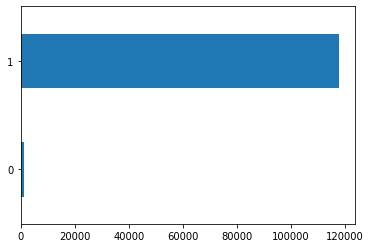

In [19]:
weather_summary['Snowfall_bin'].value_counts().sort_values().plot(kind = 'barh')

/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2163: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2163: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


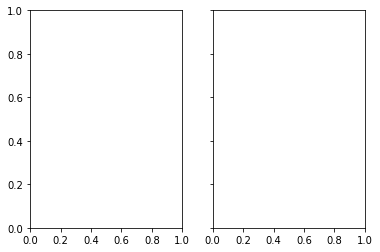

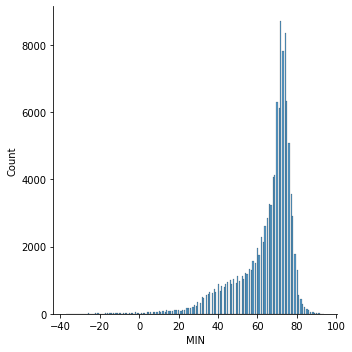

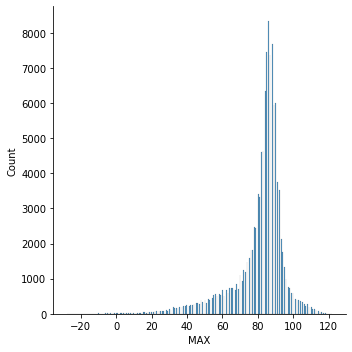

In [20]:
# call regplot on each axes
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

sns.displot(weather_summary, x="MIN", ax=ax1)
sns.displot(weather_summary, x="MAX", ax=ax2)

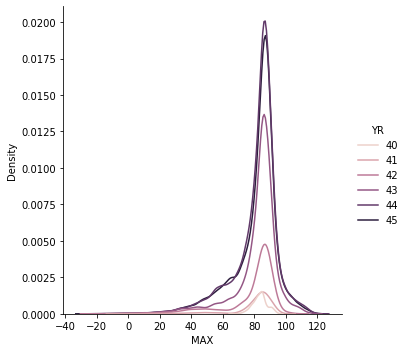

In [21]:
sns.displot(weather_summary, x="MAX", hue="YR", kind="kde")

In [22]:
weather_summary[weather_summary['STA'] == 10001]

,STA,Date,Precip,Snowfall,YR,MO,DA,MAX,MIN,SNF,MeanTemp_F,Snowfall_bin
0,10001,1942-07-01,1.016,0,42,7,1,78.0,72.0,0.0,75.0,1
1,10001,1942-07-02,0.000,0,42,7,2,84.0,71.0,0.0,77.5,1
2,10001,1942-07-03,2.540,0,42,7,3,79.0,72.0,0.0,75.5,1
3,10001,1942-07-04,2.540,0,42,7,4,80.0,72.0,0.0,76.0,1
4,10001,1942-07-05,0.000,0,42,7,5,80.0,71.0,0.0,75.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1152,10001,1945-08-27,0.000,0,45,8,27,83.0,73.0,0.0,78.0,1
1153,10001,1945-08-28,13.970,0,45,8,28,81.0,72.0,0.0,76.5,1
1154,10001,1945-08-29,3.048,0,45,8,29,79.0,72.0,0.0,75.5,1
1155,10001,1945-08-30,0.000,0,45,8,30,82.0,73.0,0.0,77.5,1


**Data Analysis & Visualization of features**
- Timeseries Dataframe: weather_summary_tm

In [23]:
## Sort the data into date order and reset index
## Create a new timeseries dataframe 
weather_summary.set_index('Date', drop=True, inplace=True)
weather_summary

,STA,Precip,Snowfall,YR,MO,DA,MAX,MIN,SNF,MeanTemp_F,Snowfall_bin
Date,,,,,,,,,,,
1942-07-01,10001,1.016,0,42,7,1,78.0,72.0,0.0,75.0,1
1942-07-02,10001,0.000,0,42,7,2,84.0,71.0,0.0,77.5,1
1942-07-03,10001,2.540,0,42,7,3,79.0,72.0,0.0,75.5,1
1942-07-04,10001,2.540,0,42,7,4,80.0,72.0,0.0,76.0,1
1942-07-05,10001,0.000,0,42,7,5,80.0,71.0,0.0,75.5,1
...,...,...,...,...,...,...,...,...,...,...,...
1945-12-27,82506,0.000,0,45,12,27,83.0,65.0,0.0,74.0,1
1945-12-28,82506,9.906,0,45,12,28,85.0,65.0,0.0,75.0,1
1945-12-29,82506,0.000,0,45,12,29,83.0,65.0,0.0,74.0,1


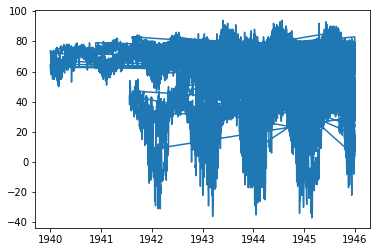

In [24]:
# Daily Analysis
plt.plot(weather_summary.MIN)

In [25]:
# Monthly Analysis


In [26]:
# ## TimeSeries Analysis 
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.lineplot(x='Date', 
#              y='MIN', 
#              data=weather_summarytrans, 
#              hue='STA'); # ';' is to avoid extra message before plot

In [27]:
weather_summary

,STA,Precip,Snowfall,YR,MO,DA,MAX,MIN,SNF,MeanTemp_F,Snowfall_bin
Date,,,,,,,,,,,
1942-07-01,10001,1.016,0,42,7,1,78.0,72.0,0.0,75.0,1
1942-07-02,10001,0.000,0,42,7,2,84.0,71.0,0.0,77.5,1
1942-07-03,10001,2.540,0,42,7,3,79.0,72.0,0.0,75.5,1
1942-07-04,10001,2.540,0,42,7,4,80.0,72.0,0.0,76.0,1
1942-07-05,10001,0.000,0,42,7,5,80.0,71.0,0.0,75.5,1
...,...,...,...,...,...,...,...,...,...,...,...
1945-12-27,82506,0.000,0,45,12,27,83.0,65.0,0.0,74.0,1
1945-12-28,82506,9.906,0,45,12,28,85.0,65.0,0.0,75.0,1
1945-12-29,82506,0.000,0,45,12,29,83.0,65.0,0.0,74.0,1


### Weather Location Analysis

In [28]:
weather_station_location.WBAN.unique()

array([33013, 33031, 33023, 33044, 12001, 11604, 82502, 82501, 82506,
       82402, 82403, 81404, 82404, 82405, 82503, 13201, 12706, 13601,
       32503, 11501, 10505, 50301, 50302, 50304, 50303, 50403, 50401,
       10807, 10806, 60701, 12701, 12801, 11615, 31401, 32301, 33205,
       33303, 50801, 32504, 31302, 81702, 34017, 34002, 34003, 34012,
       34013, 34022, 34005, 10001, 16405, 16407, 16504, 33206, 11901,
       11902, 10502, 11701, 22509, 22504, 21501, 22507, 22502, 22508,
       16101, 16201, 16202, 32701, 32801, 31701, 32815, 32907, 32803,
       32805, 32702, 32904, 32812, 32906, 33405, 33305, 33401, 33501,
       33406, 34123, 34101, 34109, 33019, 34150, 33014, 34139, 34104,
       34105, 33111, 34111, 34113, 33117, 34147, 11704, 44401, 42204,
       43305, 42206, 43302, 43307, 43201, 61501, 11601, 10002, 10101,
       10102, 33123, 13002, 13005, 13007, 13013, 12101, 80509, 80412,
       80425, 80411, 81601, 30001, 31001, 31101, 11801, 11606, 20501,
       32501, 31501,

In [29]:
weather_station_location.head()

,WBAN,NAME,STATE/COUNTRY ID,LAT,LON,ELEV,Latitude,Longitude
0,33013,AIN EL,AL,3623N,00637E,611,36.383333,6.650000
1,33031,LA SENIA,AL,3537N,00037E,88,35.616667,0.583333
2,33023,MAISON BLANCHE,AL,3643N,00314E,23,36.716667,3.216667
3,33044,TELERGMA,AL,3607N,00621E,754,36.116667,6.416667
4,12001,TINDOUF,AL,2741N,00809W,443,27.683333,-8.083333


In [30]:
weather_station_location['STATE/COUNTRY ID'].unique()

array(['AL', 'AT', 'AU', 'AZ', 'BA', 'BE', 'BN', 'BR', 'BZ', 'CS', 'CT',
       'CU', 'DR', 'DY', 'EG', 'EQ', 'ER', 'ET', 'FJ', 'FR', 'GH', 'GL',
       'GR', 'GU', 'GY', 'HA', 'HI', 'IL', 'IN', 'IQ', 'IR', 'IY', 'JM',
       'JP', 'KO', 'KU', 'LC', 'LI', 'LY', 'MC', 'MT', 'NG', 'NH', 'NI',
       'NK', 'NU', 'NZ', 'OM', 'PF', 'PH', 'PI', 'PK', 'PM', 'PQ', 'PR',
       'SG', 'SO', 'SP', 'TD', 'TI', 'TO', 'TS', 'TU', 'UK'], dtype=object)

In [31]:
SuspiciousTests_Test = pd.DataFrame(columns = ['Filename', 'Test Parameters', 'Code', 'Value'])

In [32]:
initial_min_temperature = Data.loc[0, 'Average Tank Temperature (deg F)']
initial_max_temperature = Data.loc[0, 'Average Tank Temperature (deg F)']

final_min_temperature = Data.loc[Data.index.max(), 'Average Tank Temperature (deg F)']
final_max_temperature = Data.loc[Data.index.max(), 'Average Tank Temperature (deg F)']

min_temperature = Data['T_Amb (deg F)'].min()
max_temperature = Data['T_Amb (deg F)'].max()

min_temperature_sd = Data['T_Amb (deg F)'].sd()
max_temperature_sd = Data['T_Amb (deg F)'].sd()

min_temperature_avg = Data['T_Amb (deg F)'].mean()
max_temperature_avg = Data['T_Amb (deg F)'].mean()

min_temperature_median
max_temperature_median

min_temperature_mode
max_temperature_mode

NameError: name 'Data' is not defined

## Model Building 
- Select the model that you would like to use
- Hyperparameter tuning is used to fine-tune the model in order to prevent overfitting 
- Cross-validation is performed to ensure the model performs well on the validation set 
- Model is applied to the test data set
- Save the trained model to a pickle file

## Application